# Factor Graphs


### Preliminaries

- Goal 
  - Introduction to Forney-style factor graphs and message passing-based inference 
- Materials        
  - Mandatory
    - These lecture notes   
    - Loeliger (2007), [The factor graph approach to model based signal processing](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Loeliger-2007-The-factor-graph-approach-to-model-based-signal-processing.pdf), pp. 1295-1302 (until section V)
  - Optional
    - Frederico Wadehn (2015), [Probabilistic graphical models: Factor graphs and more](https://www.youtube.com/watch?v=Fv2YbVg9Frc&t=31) video lecture (**highly recommended**)
  - References
    - Forney (2001), [Codes on graphs: normal realizations](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Forney-2001-Codes-on-graphs-normal-realizations.pdf)
   

### Why Factor Graphs?

- A probabilistic inference task gets its computational load mainly through the need for marginalization (i.e., computing integrals). E.g., for a model $p(x_1,x_2,x_3,x_4,x_5)$, the inference task $p(x_2|x_3)$ is given by 
$$\begin{align*}
p(x_2|x_3) = \frac{p(x_2,x_3)}{p(x_3)} = \frac{\idotsint p(x_1,x_2,x_3,x_4,x_5) \, \mathrm{d}x_1  \mathrm{d}x_4 \mathrm{d}x_5}{\idotsint p(x_1,x_2,x_3,x_4,x_5) \, \mathrm{d}x_1  \mathrm{d}x_2 \mathrm{d}x_4 \mathrm{d}x_5}
\end{align*}$$

- Since these computations (integrals or sums) suffer from the "curse of dimensionality", we often need to solve a simpler problem in order to get an answer. 

- Factor graphs provide a computationally efficient approach to solving inference problems **if the probabilistic model can be factorized**. 

- <a id='factorization-helps'>Factorization helps</a>. For instance, if $p(x_1,x_2,x_3,x_4,x_5) = p(x_1)p(x_2,x_3)p(x_4)p(x_5|x_4)$, then

$$\begin{align*}
p(x_2|x_3) &= \frac{\idotsint p(x_1)p(x_2,x_3)p(x_4)p(x_5|x_4) \, \mathrm{d}x_1  \mathrm{d}x_4 \mathrm{d}x_5}{\idotsint p(x_1)p(x_2,x_3)p(x_4)p(x_5|x_4) \, \mathrm{d}x_1  \mathrm{d}x_2 \mathrm{d}x_4 \mathrm{d}x_5} 
  = \frac{p(x_2,x_3)}{\int p(x_2,x_3) \mathrm{d}x_2}
\end{align*}$$

which is computationally much cheaper than the general case above.

- In this lesson, we discuss how computationally efficient inference in *factorized* probability distributions can be automated by message passing-based inference in factor graphs.

###  Factor Graph Construction Rules

- Consider a function 
$$
f(x_1,x_2,x_3,x_4,x_5) = f_a(x_1,x_2,x_3) \cdot f_b(x_3,x_4,x_5) \cdot f_c(x_4)
$$

- The factorization of this function can be graphically represented by a **Forney-style Factor Graph** (FFG):

<p style="text-align:center;"><img src="./figures/ffg-example-1.png" width="400px"></p>

- An FFG is an **undirected** graph subject to the following construction rules ([Forney, 2001](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Forney-2001-Codes-on-graphs-normal-realizations.pdf))

  1. A **node** for every factor;
  1. An **edge** (or **half-edge**) for every variable;
  1. Node $f_\bullet$ is connected to edge $x$ **iff** variable $x$ appears in factor $f_\bullet$.

- A **configuration** is an assigment of values to all variables.

- A configuration $\omega=(x_1,x_2,x_3,x_4,x_5)$ is said to be **valid** iff $f(\omega) \neq 0$
  

###  Equality Nodes for Branching Points


- Note that a variable can appear in maximally two factors in an FFG (since an edge has only two end points).

- Consider the factorization (where $x_2$ appears in three factors) 

$$
 f(x_1,x_2,x_3,x_4) = f_a(x_1,x_2)\cdot f_b(x_2,x_3) \cdot f_c(x_2,x_4)
$$

- For the factor graph representation, we will instead consider the function $g$, defined as
$$\begin{align*}
 g(x_1,x_2&,x_2^\prime,x_2^{\prime\prime},x_3,x_4) 
  = f_a(x_1,x_2)\cdot f_b(x_2^\prime,x_3) \cdot f_c(x_2^{\prime\prime},x_4) \cdot f_=(x_2,x_2^\prime,x_2^{\prime\prime})
\end{align*}$$
  where 
$$
f_=(x_2,x_2^\prime,x_2^{\prime\prime}) \triangleq \delta(x_2-x_2^\prime)\, \delta(x_2-x_2^{\prime\prime})
$$

 <p style="text-align:center;"><img src="./figures/ffg-wEquality-node.png" width="450px"></p>
  

###  Equality Nodes for Branching Points, cont'd

- Note that through introduction of auxiliary variables $X_2^\prime$ and $X_2^{\prime\prime}$ and a factor $f_=(x_2,x_2^\prime,x_2^{\prime\prime})$ each variable in $g$ appears in maximally two factors. 

- The constraint $f_=(x,x^\prime,x^{\prime\prime})$ enforces that $X=X^\prime=X^{\prime\prime}$ **for every valid configuration**.

- Since $f$ is a marginal of $g$, i.e., 
$$
f(x_1,x_2,x_3,x_4) = \iint g(x_1,x_2,x_2^\prime,x_2^{\prime\prime},x_3,x_4)\, \mathrm{d}x_2^\prime \mathrm{d}x_2^{\prime\prime}
$$
it follows that any inference problem on $f$ can be executed by a corresponding inference problem on $g$, e.g.,
$$\begin{align*}
f(x_1 \mid x_2) &\triangleq \frac{\iint f(x_1,x_2,x_3,x_4) \,\mathrm{d}x_3 \mathrm{d}x_4 }{ \idotsint f(x_1,x_2,x_3,x_4) \,\mathrm{d}x_1 \mathrm{d}x_3 \mathrm{d}x_4} \\
  &= \frac{\idotsint g(x_1,x_2,x_2^\prime,x_2^{\prime\prime},x_3,x_4) \,\mathrm{d}x_2^\prime \mathrm{d}x_2^{\prime\prime} \mathrm{d}x_3 \mathrm{d}x_4 }{ \idotsint g(x_1,x_2,x_2^\prime,x_2^{\prime\prime},x_3,x_4) \,\mathrm{d}x_1 \mathrm{d}x_2^\prime \mathrm{d}x_2^{\prime\prime} \mathrm{d}x_3 \mathrm{d}x_4} \\
  &= g(x_1 \mid x_2)
\end{align*}$$

- $\Rightarrow$ **Any factorization of a global function $f$ can be represented by a Forney-style Factor Graph**.

### Probabilistic Models as Factor Graphs

- FFGs can be used to express conditional independence (factorization) in probabilistic models. 

- For example, the (previously shown) graph for 
$f_a(x_1,x_2,x_3) \cdot f_b(x_3,x_4,x_5) \cdot f_c(x_4)$ 
could represent the probabilistic model
$$
p(x_1,x_2,x_3,x_4,x_5) = p(x_1,x_2|x_3) \cdot p(x_3,x_5|x_4) \cdot p(x_4)
$$
where we identify 
$$\begin{align*}
f_a(x_1,x_2,x_3) &= p(x_1,x_2|x_3) \\
f_b(x_3,x_4,x_5) &= p(x_3,x_5|x_4) \\
f_c(x_4) &= p(x_4)
\end{align*}$$

- This is the graph

<p style="text-align:center;"><img src="./figures/ffg-example-prob-model.png" width="400px"></p>

### Inference by Closing Boxes

- Factorizations provide opportunities to cut on the amount of needed computations when doing inference. In what follows, we will use FFGs to process these opportunities in an automatic way by message passing between the nodes of the graph. 

- Assume we wish to compute the marginal
$$
\bar{f}(x_3) \triangleq \sum_{x_1,x_2,x_4,x_5,x_6,x_7}f(x_1,x_2,\ldots,x_7) 
$$
for a model $f$ with given factorization 
$$
f(x_1,x_2,\ldots,x_7) = f_a(x_1) f_b(x_2) f_c(x_1,x_2,x_3) f_d(x_4) f_e(x_3,x_4,x_5) f_f(x_5,x_6,x_7) f_g(x_7)
$$ 
- The FFG for $f$ is (we will discuss the usage of directed edges below):

<p style="text-align:center;"><img src="./figures/ffg-message-passing-1.png" width="600px"><p style="text-align:center;">

- Due to the factorization and the [Generalized Distributive Law](https://en.wikipedia.org/wiki/Generalized_distributive_law), we can decompose this sum-of-products to the following product-of-sums:
$$\begin{align*}\bar{f}&(x_3) = \\
  &\underbrace{ \Bigg( \sum_{x_1,x_2} \underbrace{f_a(x_1)}_{\overrightarrow{\mu}_{X_1}(x_1)}\, \underbrace{f_b(x_2)}_{\overrightarrow{\mu}_{X_2}(x_2)}\,f_c(x_1,x_2,x_3)\Bigg) }_{\overrightarrow{\mu}_{X_3}(x_3)} 
  \underbrace{ \cdot\Bigg( \sum_{x_4,x_5} \underbrace{f_d(x_4)}_{\overrightarrow{\mu}_{X_4}(x_4)}\,f_e(x_3,x_4,x_5) \cdot \underbrace{ \big( \sum_{x_6,x_7} f_f(x_5,x_6,x_7)\,\underbrace{f_g(x_7)}_{\overleftarrow{\mu}_{X_7}(x_7)}\big) }_{\overleftarrow{\mu}_{X_5}(x_5)} \Bigg) }_{\overleftarrow{\mu}_{X_3}(x_3)}
\end{align*}$$
which is computationally (much) lighter than executing the full sum $\sum_{x_1,\ldots,x_7}f(x_1,x_2,\ldots,x_7)$

<p style="text-align:center;"><img src="./figures/ffg-message-passing.png" width="700px"></p>

- Note that the new factor $\overrightarrow{\mu}_{X_3}(x_3)$ is obtained by multiplying all enclosed factors ($f_a$, $f_b, f_c$) by the red dashed box, followed by marginalization (summing) over all enclosed variables ($x_1$, $x_2$).
  

- This is the **Closing the Box**-rule, which is a general recipe for marginalization of latent variables (inside the box) and leads to a new factor that has the variables (edges) that cross the box as arguments. For instance, the argument of the remaining factor $\overrightarrow{\mu}_{X_3}(x_3)$ is the variable on the edge that crosses the red box ($x_3$).


- Hence, $\overrightarrow{\mu}_{X_3}(x_3)$ can be interpreted as a **message from the red box toward variable** $x_3$.

- We drew _directed edges_ in the FFG in order to distinguish forward messages $\overrightarrow{\mu}_\bullet(\cdot)$ (in the same direction as the arrow of the edge) from backward messages $\overleftarrow{\mu}_\bullet(\cdot)$ (in opposite direction). This is just a notational convenience since an FFG is computationally an undirected graph. 

### Sum-Product Algorithm

- Closing-the-box can also be interpreted as a **message update rule** for an outgoing message from a node. For a node $f(y,x_1,\ldots,x_n)$ with incoming messages $\overrightarrow{\mu}_{X_1}(x_1), \overrightarrow{\mu}_{X_1}(x_1), \ldots,\overrightarrow{\mu}_{X_n}(x_n)$, the outgoing message is given by ([Loeliger (2007), pg.1299](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Loeliger-2007-The-factor-graph-approach-to-model-based-signal-processing.pdf)): 

$$ \boxed{
\underbrace{\overrightarrow{\mu}_{Y}(y)}_{\substack{ \text{outgoing}\\ \text{message}}} = \sum_{x_1,\ldots,x_n} \underbrace{\overrightarrow{\mu}_{X_1}(x_1)\cdots \overrightarrow{\mu}_{X_n}(x_n)}_{\substack{\text{incoming} \\ \text{messages}}} \cdot \underbrace{f(y,x_1,\ldots,x_n)}_{\substack{\text{node}\\ \text{function}}} }
$$

<p style="text-align:center;"><img src="./figures/ffg-sum-product.png" width="500px"></p>

- This is called the **Sum-Product Message** (SPM) update rule. 

- Note that all SPM update rules can be computed from information that is **locally available** at each node.

- If the factor graph for a function $f$ has **no cycles** (i.e., the graph is a tree), then the marginal $\bar{f}(x_3) = \sum_{x_1,x_2,x_4,x_5,x_6,x_7}f(x_1,x_2,\ldots,x_7)$ is given by multiplying the forward and backward messages on that edge:

$$ \boxed{
\bar{f}(x_3) = \overrightarrow{\mu}_{X_3}(x_3)\cdot \overleftarrow{\mu}_{X_3}(x_3)}
$$

- It follows that the marginal $\bar{f}(x_3) = \sum_{x_1,x_2,x_4,x_5,x_6,x_7}f(x_1,x_2,\ldots,x_7)$ can be efficiently computed through sum-product messages. Executing inference through SP message passing is called the **Sum-Product Algorithm**.

### Message Passing Schedules

- In a tree graph, start with messages from the terminals and keep passing messages through the internal nodes towards the "target" variable ($x_3$ in above problem) until you have both the forward and backward message for the target variable. 

- In a tree graph, if you continue to pass messages throughout the graph, the Sum-Product Algorithm computes **exact** marginals for all hidden variables.

- If the graph contains cycles, we have in principle an infinite tree by "unrolling" the graph. In this case, the SP Algorithm is not guaranteed to find exact marginals. In practice, if we apply the SP algorithm for just a few iterations ("unrolls"), then we often find satisfying approximate marginals.   

### Terminal Nodes and Processing Observations 

- We can use terminal nodes represent observations, e.g., add a factor $f(𝑦)=𝛿(𝑦−3)$ to terminate the half-edge for variable $𝑌$  if  $𝑦=3$  is observed.

<p style="text-align:center;"><img src="./figures/ffg-observation-y-3.png" width="600px"></p>

- Terminal nodes that carry observations are denoted by small black boxes.


  
- The message out of a **terminal node** (attached to only 1 edge) is the factor itself. For instance, closing a box around terminal node $f_a(x_1)$ would lead to $$\overrightarrow{\mu}_{X_1}(x_1) \triangleq \sum_{ \stackrel{ \textrm{enclosed} }{ \textrm{variables} } } \;\prod_{\stackrel{ \textrm{enclosed} }{ \textrm{factors} }} f_a(x_1) = f_a(x_1)\,$$
since there are no enclosed variables. 

<p style="text-align:center;"><img src="./figures/ffg-terminal-node-message.png" width="250px"></p>
 

- The message from a half-edge is $1$ (one). You can verify this by imagining that a half-edge $x$ can be terminated by a node function $f(x)=1$ without affecting any inference issue.

### Automating Bayesian Inference by Message Passing

- The foregoing message update rules can be worked out in closed-form and put into tables (e.g., see Tables 1 through 6 in [Loeliger (2007)](./files/Loeliger-2007-The-factor-graph-approach-to-model-based-signal-processing.pdf) for many standard factors such as essential probability distributions and operations such as additions, fixed-gain multiplications and branching (equality nodes).

- In the optional slides below, we have worked out a few of these update rules, eg, for the [equality node](#sp-for-equality-node), the [addition node](#sp-for-addition-node) and the [multiplication node](#sp-for-multiplication-node).

- If the update rules for all node types in a graph have been tabulated, then inference by message passing comes down to executing a set of table-lookup operations, thus creating a completely **automatable Bayesian inference framework**. 

- In our research lab [BIASlab](http://biaslab.org) (FLUX 7.060), we are developing [ForneyLab](https://github.com/biaslab/ForneyLab.jl), which is a (Julia) toolbox for automating Bayesian inference by message passing in a factor graph.


### Example: Bayesian Linear Regression by Message Passing


- Assume we want to estimate some function $f: \mathbb{R}^D \rightarrow \mathbb{R}$ from a given data set $D = \{(x_1,y_1), \ldots, (x_N,y_N)\}$, with model assumption $y_i = f(x_i) + \epsilon_i$.

#### model specification 

- We will assume a linear model with white Gaussian noise and a Gaussian prior on the coefficients $w$:
$$\begin{align*}
  y_i &= w^T x_i  + \epsilon_i \\
  \epsilon_i &\sim \mathcal{N}(0, \sigma^2) \\ 
  w &\sim \mathcal{N}(0,\Sigma)
\end{align*}$$
or equivalently
$$\begin{align*}
p(w,\epsilon,D) &= \overbrace{p(w)}^{\text{weight prior}} \prod_{i=1}^N  \overbrace{p(y_i\,|\,x_i,w,\epsilon_i)}^{\text{regression model}} \overbrace{p(\epsilon_i)}^{\text{noise model}} \\
  &= \mathcal{N}(w\,|\,0,\Sigma) \prod_{i=1}^N \delta(y_i - w^T x_i - \epsilon_i) \mathcal{N}(\epsilon_i\,|\,0,\sigma^2) 
\end{align*}$$

#### Inference (parameter estimation)

- We are interested in inferring the posterior $p(w|D)$. We will execute inference by message passing on the FFG for the model.

- The left figure shows the factor graph for this model. 
- The right figure shows the message passing scheme. 
  
<p style="text-align:center;"><img src="./figures/ffg-bayesian-linear-regression.png" width="500px"></p>


#### CODE EXAMPLE

Let's solve this problem by message passing-based inference with Julia's FFG toolbox [ForneyLab](http://forneylab.org).

In [1]:
using Pkg;Pkg.activate("probprog/workspace/");Pkg.instantiate();
IJulia.clear_output();

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278


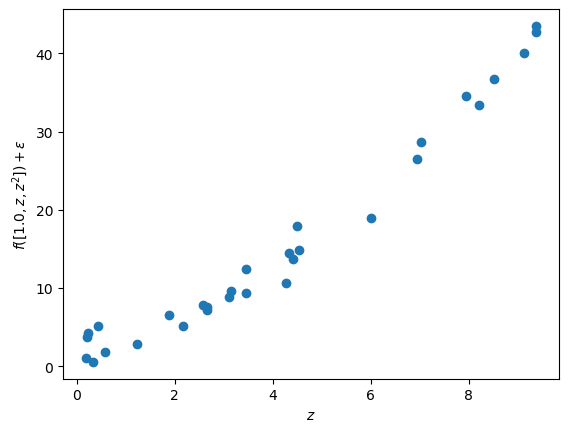

In [2]:
using PyPlot, ForneyLab, LinearAlgebra

# Parameters
Σ = 1e5 * Diagonal(I,3) # Covariance matrix of prior on w
σ2 = 2.0         # Noise variance

# Generate data set
w = [1.0; 2.0; 0.25]
N = 30
z = 10.0*rand(N)
x_train = [[1.0; z; z^2] for z in z] # Feature vector x = [1.0; z; z^2]
f(x) = (w'*x)[1]
y_train = map(f, x_train) + sqrt(σ2)*randn(N) # y[i] = w' * x[i] + ϵ
scatter(z, y_train); xlabel(L"z"); ylabel(L"f([1.0, z, z^2]) + \epsilon");


Now build the factor graph in ForneyLab, perform sum-product message passing and plot results (mean of posterior).

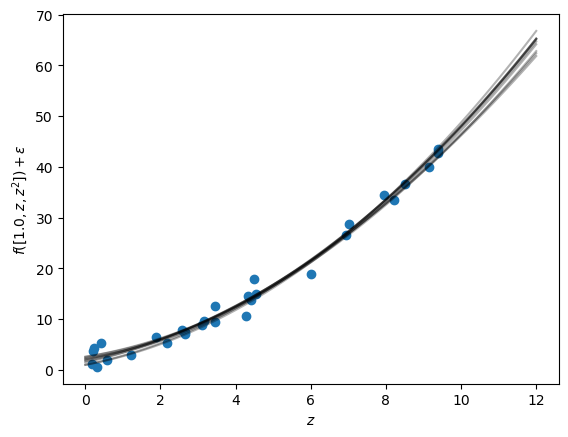

Posterior distribution of w: 𝒩(xi=[2.35e+02, 1.54e+03, 1.17e+04], w=[[15.00, 61.42, 3.84e+02][61.42, 3.84e+02, 2.81e+03][3.84e+02, 2.81e+03, 2.24e+04]])



In [3]:
# Build factorgraph

fg = FactorGraph()
@RV w ~ GaussianMeanVariance(constant(zeros(3)), constant(Σ, id=:Σ), id=:w) # p(w)
for t=1:N
    x_t = Variable(id=:x_*t)
    d_t = Variable(id=:d_*t) # d=w'*x
    DotProduct(d_t, x_t, w) # p(f|w,x)
    @RV y_t ~ GaussianMeanVariance(d_t, constant(σ2, id=:σ2_*t), id=:y_*t) # p(y|d)
    placeholder(x_t, :x, index=t, dims=(3,))
    placeholder(y_t, :y, index=t);
end

# Build and run message passing algorithm
algo = messagePassingAlgorithm(w)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code))
data = Dict(:x => x_train, :y => y_train)
w_posterior_dist = step!(data)[:w]

# Plot result
println("Posterior distribution of w: $(w_posterior_dist)")
scatter(z, y_train); xlabel(L"z"); ylabel(L"f([1.0, z, z^2]) + \epsilon");
z_test = collect(0:0.2:12)
x_test = [[1.0; z; z^2] for z in z_test]
for sample=1:10
    w = ForneyLab.sample(w_posterior_dist)
    f_est(x) = (w'*x)[1]
    plot(z_test, map(f_est, x_test), "k-", alpha=0.3);
end

## <center>OPTIONAL SLIDES</center>

### <a id="sp-for-equality-node">Sum-Product Messages for the Equality Node</a>

- Let´s compute the SP messages for the **equality node** $f_=(x,y,z) = \delta(z-x)\delta(z-y)$: 

<p style="text-align:center;"><img src="./figures/ffg-equality-node.png" width="250px"></p>

$$\begin{align*}
\overrightarrow{\mu}_{Z}(z) &= \iint  \overrightarrow{\mu}_{X}(x) \overrightarrow{\mu}_{Y}(y) \,\delta(z-x)\delta(z-y) \,\mathrm{d}x \mathrm{d}y \\
   &=  \overrightarrow{\mu}_{X}(z)  \int  \overrightarrow{\mu}_{Y}(y) \,\delta(z-y) \,\mathrm{d}y \\
   &=  \overrightarrow{\mu}_{X}(z) \overrightarrow{\mu}_{Y}(z) 
\end{align*}$$

- By symmetry, this also implies (for the same equality node) that

$$\begin{align*}
\overleftarrow{\mu}_{X}(x) &= \overrightarrow{\mu}_{Y}(x) \overleftarrow{\mu}_{Z}(x) \quad \text{and} \\
\overleftarrow{\mu}_{Y}(y) &= \overrightarrow{\mu}_{X}(y) \overleftarrow{\mu}_{Z}(y)\,.
\end{align*}$$

- Let us now consider the case of Gaussian messages $\overrightarrow{\mu}_{X}(x) = \mathcal{N}(x|\overrightarrow{m}_X,\overrightarrow{V}_X)$, $\overrightarrow{\mu}_{Y}(y) = \mathcal{N}(y| \overrightarrow{m}_Y,\overrightarrow{V}_Y)$ and $\overrightarrow{\mu}_{Z}(z) = \mathcal{N}(z|\overrightarrow{m}_Z,\overrightarrow{V}_Z)$. Let´s also define the precision matrices $\overrightarrow{W}_X \triangleq \overrightarrow{V}_X^{-1}$ and similarly for $Y$ and $Z$. Then applying the SP update rule leads to multiplication of two Gaussian distributions, resulting in 

$$\begin{align*}
\overrightarrow{W}_Z &= \overrightarrow{W}_X + \overrightarrow{W}_Y \\ 
\overrightarrow{W}_Z \overrightarrow{m}_z &= \overrightarrow{W}_X \overrightarrow{m}_X + \overrightarrow{W}_Y \overrightarrow{m}_Y
\end{align*}$$

- It follows that **message passing through an equality node is similar to applying Bayes rule**, i.e., fusion of two information sources. Does this make sense?

###  <a id="sp-for-addition-node">Sum-Product Messages for the Addition Node</a>

- Next, consider an **addition node** $f_+(x,y,z) = \delta(z-x-y)$:  
<p style="text-align:center;"><img src="./figures/ffg-addition-node.png" width="250px"></p>

$$\begin{align*}
\overrightarrow{\mu}_{Z}(z) &= \iint  \overrightarrow{\mu}_{X}(x) \overrightarrow{\mu}_{Y}(y) \,\delta(z-x-y) \,\mathrm{d}x \mathrm{d}y \\
   &=  \int  \overrightarrow{\mu}_{X}(x) \overrightarrow{\mu}_{Y}(z-x) \,\mathrm{d}x \,, 
\end{align*}$$
i.e., $\overrightarrow{\mu}_{Z}$ is the convolution of the messages $\overrightarrow{\mu}_{X}$ and $\overrightarrow{\mu}_{Y}$.

- Of course, for Gaussian messages, these update rules evaluate to

$$\begin{align*}
\overrightarrow{m}_Z &= \overrightarrow{m}_X + \overrightarrow{m}_Y \\
\overrightarrow{V}_z &= \overrightarrow{V}_X + \overrightarrow{V}_Y \,.
\end{align*}$$

- <div class="exercise"><b>Exercise</b>: For the same summation node, work out the SP update rule for the backward message $\overleftarrow{\mu}_{X}(x)$ as a function of $\overrightarrow{\mu}_{Y}(y)$ and  $\overleftarrow{\mu}_{Z}(z)$. And further refine the answer for Gaussian messages. </div>   

###  <a id="sp-for-multiplication-node">Sum-Product Messages for Multiplication Nodes</a>
- Next, let us consider a **multiplication** by a fixed (invertible matrix) gain $f_A(x,y) = \delta(y-Ax)$

<p style="text-align:center;"><img src="./figures/ffg-gain-node.png" width="250px"></p>

$$\begin{align*}
\overrightarrow{\mu}_{Y}(y) = \int  \overrightarrow{\mu}_{X}(x) \,\delta(y-Ax) \,\mathrm{d}x = \overrightarrow{\mu}_{X}(A^{-1}y) \,.
\end{align*}$$

- For a Gaussian message input message $\overrightarrow{\mu}_{X}(x) = \mathcal{N}(x|\overrightarrow{m}_{X},\overrightarrow{V}_{X})$, the output message is also Gaussian with 
$$\begin{align*}
\overrightarrow{m}_{Y} = A\overrightarrow{m}_{X} \,,\,\text{and}\,\,
\overrightarrow{V}_{Y} = A\overrightarrow{V}_{X}A^T
\end{align*}$$
since 
$$\begin{align*}
\overrightarrow{\mu}_{Y}(y) &= \overrightarrow{\mu}_{X}(A^{-1}y) \\
  &\propto \exp \left( -\frac{1}{2} \left( A^{-1}y - \overrightarrow{m}_{X}\right)^T \overrightarrow{V}_{X}^{-1} \left(  A^{-1}y - \overrightarrow{m}_{X}\right)\right) \\
   &= \exp \big( -\frac{1}{2} \left( y - A\overrightarrow{m}_{X}\right)^T \underbrace{A^{-T}\overrightarrow{V}_{X}^{-1} A^{-1}}_{(A \overrightarrow{V}_{X} A^T)^{-1}} \left( y - A\overrightarrow{m}_{X}\right)\big) \\
  &\propto  \mathcal{N}(A\overrightarrow{m}_{X},A\overrightarrow{V}_{X}A^T) \,.
\end{align*}$$

- <div class="exercise"><b>Excercise</b>: Proof that, for the same factor $\delta(y-Ax)$ and Gaussian messages, the (backward) sum-product message $\overleftarrow{\mu}_{X}$ is given by 
$$\begin{align*}
\overleftarrow{\xi}_{X} &= A^T\overleftarrow{\xi}_{Y} \\
\overleftarrow{W}_{X} &= A^T\overleftarrow{W}_{Y}A
\end{align*}$$
where $\overleftarrow{\xi}_X \triangleq \overleftarrow{W}_X \overleftarrow{m}_X$ and $\overleftarrow{W}_{X} \triangleq \overleftarrow{V}_{X}^{-1}$ (and similarly for $Y$).</div>


### Code example: Gaussian forward and backward messages for the Addition node

Let's calculate the Gaussian forward and backward messages for the addition node in ForneyLab. 
<p style="text-align:center;"><img src="./figures/ffg-addition-node.png" width="250px"></p>

In [4]:
# Forward message towards Z
fg = FactorGraph()
@RV x ~ GaussianMeanVariance(constant(1.0), constant(1.0), id=:x) 
@RV y ~ GaussianMeanVariance(constant(2.0), constant(1.0), id=:y)
@RV z = x + y; z.id = :z

q = PosteriorFactorization(fg)

algo1 = messagePassingAlgorithm(z, id=:_forward_Z)
source_code1 = algorithmSourceCode(algo1)
eval(Meta.parse(source_code1))
msg_forward_Z = step_forward_Z!(Dict())[:z]
print("Forward message on Z: $(msg_forward_Z)")

Forward message on Z: 𝒩(m=3.00, v=2.00)


In [5]:
# Backward message towards X
fg = FactorGraph()
@RV x; x.id=:x
@RV y ~ GaussianMeanVariance(constant(2.0), constant(1.0), id=:y)
@RV z = x + y
GaussianMeanVariance(z, constant(3.0), constant(1.0), id=:z) 

q = PosteriorFactorization(fg)

algo2 = messagePassingAlgorithm(x, id=:_backward_X)
source_code2 = algorithmSourceCode(algo2)
eval(Meta.parse(source_code2))
msg_backward_X = step_backward_X!(Dict())[:x]
print("Backward message on X: $(msg_backward_X)")

Backward message on X: 𝒩(m=1.00, v=2.00)


### Code Example: forward and backward messages for the Matrix Multiplication node

In the same way we can also investigate the forward and backward messages for the matrix multiplication ("gain") node 
<p style="text-align:center;"><img src="./figures/ffg-gain-node.png" width="250px"></p>

In [6]:
# Forward message towards Y
fg = FactorGraph()
@RV x ~ GaussianMeanVariance(1.0, 1.0)
@RV y = 4.0 * x

q = PosteriorFactorization(fg)
#This is where the bugs live..
algo3 = messagePassingAlgorithm(y, id=:_y_fwd)
source_code3 = algorithmSourceCode(algo3)
eval(Meta.parse(source_code3))
msg_forward_Y = step_y_fwd!(Dict())[:y]
print("Forward message on Y: $(msg_forward_Y)")

Forward message on Y: 𝒩(m=4.00, v=16.00)


 
 ### Example: Sum-Product Algorithm to infer a posterior
 
 - Consider a generative model 
$$p(x,y_1,y_2) = p(x)\,p(y_1|x)\,p(y_2|x) .$$ 
  - This model expresses the assumption that $Y_1$ and $Y_2$ are independent measurements of $X$.

<p style="text-align:center;"><img src="./figures/ffg-observations.png" width="375px"></p>

 
- Assume that we are interested in the posterior for $X$ after observing $Y_1= \hat y_1$ and $Y_2= \hat y_2$. The posterior for $X$ can be inferred by applying the sum-product algorithm to the following graph:

<p style="text-align:center;"><img src="./figures/ffg-observations-2.png" width="650px"></p>

 - (Note that) we usually draw terminal nodes for observed variables in the graph by smaller solid-black squares. This is just to help the visualization of the graph, since the computational rules are no different than for other nodes. 

### Code for Sum-Product Algorithm to infer  a posterior

We'll use ForneyLab to build the above graph, and perform sum-product message passing to infer the posterior $p(x|y_1,y_2)$. We assume $p(y_1|x)$ and $p(y_2|x)$ to be Gaussian likelihoods with known variances:
$$\begin{align*}
    p(y_1\,|\,x) &= \mathcal{N}(y_1\,|\,x, v_{y1}) \\
    p(y_2\,|\,x) &= \mathcal{N}(y_2\,|\,x, v_{y2})
\end{align*}$$
Under this model, the posterior is given by:
$$\begin{align*}
    p(x\,|\,y_1,y_2) &\propto \overbrace{p(y_1\,|\,x)\,p(y_2\,|\,x)}^{\text{likelihood}}\,\overbrace{p(x)}^{\text{prior}} \\
    &=\mathcal{N}(x\,|\,\hat{y}_1, v_{y1})\, \mathcal{N}(x\,|\,\hat{y}_2, v_{y2}) \, \mathcal{N}(x\,|\,m_x, v_x) 
\end{align*}$$
so we can validate the answer by solving the Gaussian multiplication manually.

In [7]:
using ForneyLab 

# Data
y1_hat = 1.0
y2_hat = 2.0

# Construct the factor graph
fg = FactorGraph()
@RV x  ~ GaussianMeanVariance(constant(0.0), constant(4.0), id=:x) # Node p(x)
@RV y1 ~ GaussianMeanVariance(x, constant(1.0))            # Node p(y1|x)
@RV y2 ~ GaussianMeanVariance(x, constant(2.0))            # Node p(y2|x)
Clamp(y1, y1_hat)                  # Terminal (clamp) node for y1
Clamp(y2, y2_hat)                  # Terminal (clamp) node for y2
# draw(fg) # draw the constructed factor graph

# Perform sum-product message passing
algo4 = messagePassingAlgorithm(x, id=:_x)
source_code4 = algorithmSourceCode(algo4)
eval(Meta.parse(source_code4))
x_marginal = step_x!(Dict())[:x]
println("Sum-product message passing result: p(x|y1,y2) = 𝒩($(mean(x_marginal)),$(var(x_marginal)))")

# Calculate mean and variance of p(x|y1,y2) manually by multiplying 3 Gaussians (see lesson 4 for details)
v = 1 / (1/4 + 1/1 + 1/2)
m = v * (0/4 + y1_hat/1.0 + y2_hat/2.0)
println("Manual result: p(x|y1,y2) = 𝒩($(m), $(v))")

Sum-product message passing result: p(x|y1,y2) = 𝒩(1.1428571428571428,0.5714285714285714)
Manual result: p(x|y1,y2) = 𝒩(1.1428571428571428, 0.5714285714285714)


In [8]:
# Backward message towards X
fg = FactorGraph()
x = Variable(id=:x)
@RV y = constant(4.0) * x
GaussianMeanVariance(y, constant(2.0), constant(1.0))

q = PosteriorFactorization(fg)

algo5 = messagePassingAlgorithm(x, id=:_x_fwd2)
source_code5 = algorithmSourceCode(algo5)
eval(Meta.parse(source_code5))
msg_backward_X = step_x_fwd2!(Dict())[:x]
print("Backward message on X: $(msg_backward_X)")

Backward message on X: 𝒩(xi=8.00, w=16.00)


In [9]:
open("../../styles/aipstyle.html") do f display("text/html", read(f, String)) end


<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->